<a href="https://colab.research.google.com/github/melvin-02/Image-Captioning-Project/blob/master/Caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/Caption generator/Flickr8k_Dataset.zip"

In [ ]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/Caption generator/Flickr8k_text.zip"

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/Language Model/glove.42B.300d.zip"

In [ ]:
import tensorflow as tf
import os 
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import add
import string
import itertools
import math

In [ ]:
 def extract_features(directory):

  model = InceptionV3()
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)	
  print(model.summary())

  features = dict()
  for name in listdir(directory):		
    filename = directory + '/' + name
    image = load_img(filename, target_size=(299,299))	
    image = img_to_array(image)	
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))		
    image = preprocess_input(image)	
    feature = model.predict(image, verbose=0)
    image_id = name.split('.')[0]	
    features[image_id] = feature
    print('>%s' % name)
  
  return features
 
directory = '/content/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
dump(features, open('/content/drive/MyDrive/Colab Notebooks/Caption generator/features.pkl', 'wb'))

In [ ]:
def load_description(filepath):
  
  with open(filepath, "r") as f:
    doc = f.read()
  
  mappings = dict()
  for line in doc.split("\n"):
    if len(line) < 2:
      continue
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    image_desc = " ".join(image_desc)

    if image_id not in mappings:
      mappings[image_id] = list()
    mappings[image_id].append(image_desc)

  return mappings

    

In [ ]:
filepath = "/content/Flickr8k.token.txt"
descriptions = load_description(filepath)

print(len(descriptions))

8092


In [ ]:
def clean_description(mappings):
  table = str.maketrans('', '', string.punctuation)
  for id, desc_list in mappings.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      desc = desc.split()
      desc = [word.lower() for word in desc]
      desc = [word.translate(table) for word in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      desc_list[i] = " ".join(desc)
  
  return mappings


In [ ]:
cleaned = clean_description(descriptions)

In [ ]:
def vocabulary_set(descriptions):
  vocab = set()
  for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

In [ ]:
vocab = vocabulary_set(cleaned)
print(len(vocab))

8763


In [ ]:
def save_descriptons(descriptions):
  
  lines = []
  for id, desc_lst in descriptions.items():
    for desc in desc_lst:
      lines.append(id + " " + desc)
  data = "\n".join(lines)

  with open("/content/drive/MyDrive/Colab Notebooks/Caption generator/descriptions.txt", "w") as f:
    f.write(data)


In [ ]:
save_descriptons(cleaned)

In [ ]:
def load_embeddings(filepath):

  embeddings_dict = {}
  with open(filepath, 'r') as f:
    for line in f:
      word, embedding = line.split(maxsplit =1)
      embedding = np.fromstring(embedding, sep=' ')
      embeddings_dict[word] = embedding
  
  return embeddings_dict

In [ ]:
glove_embeddings = load_embeddings('/content/glove.42B.300d.txt')
print(len(glove_embeddings))

1917494


In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/Caption generator/features.pkl", "rb") as f:
  features = pickle.load(f)
with open("/content/drive/MyDrive/Colab Notebooks/Caption generator/descriptions.txt", "r") as f:
  descriptions = f.read()


In [ ]:
def load_set(filepath):

  with open(filepath, 'r') as f:
    data = f.read()
  identifiers = []
  for line in data.split("\n"):
    if len(line) < 1:
      continue
    identifiers.append(line.split('.')[0])
  return set(identifiers)

def load_photo_features(filepath, dataset):

  with open(filepath, "rb") as f:
    features = pickle.load(f)
  photo_features = {}
  for id in dataset:
    photo_features[id] = features[id]
  return photo_features

def load_cleaned_descriptions(filepath, dataset):

  with open(filepath, 'r') as f:
    data = f.read()
  descriptions = {}
  for line in data.split('\n'):
    tokens = line.split()
    id, desc = tokens[0], tokens[1:]
    if id in dataset:
      if id not in descriptions:
        descriptions[id] = []
      desc_seq = 'startseq ' + ' '.join(desc) + ' endseq'
      descriptions[id].append(desc_seq)
  return descriptions

In [ ]:
def create_tokenizer(descriptions):

  all_desc = []
  for id in descriptions.keys():
    [all_desc.append(d) for d in descriptions[id]]
  tokenizer = Tokenizer(num_words=2000)
  tokenizer.fit_on_texts(all_desc)
  return tokenizer


In [ ]:
def max_seq_len(descriptions):
  all_desc = []
  for id in descriptions.keys():
    [all_desc.append(d) for d in descriptions[id]]
  return max(len(d.split()) for d in all_desc)

In [ ]:
def data_genertor(tokenizer, num_photos, descriptions:dict, photos:dict, vocab_size, max_size):
  
  X1, X2, y = list(), list(), list()
  n = 0
  while True:
    for key, desc_lst in descriptions.items(): 
      n += 1 
      photo = photos[key][0]
      for desc in desc_lst:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
          input_seq, target_seq = seq[:i], seq[i]
          input_seq = pad_sequences([input_seq], maxlen=max_size)[0]
          target_seq = to_categorical([target_seq], num_classes=vocab_size)[0]

          X1.append(photo)
          X2.append(input_seq)
          y.append(target_seq)

      if n == num_photos:
        yield [np.array(X1), np.array(X2)] , np.array(y)
        X1, X2, y = list(), list(), list()
        n = 0


In [ ]:
train_desc_path = "/content/Flickr_8k.trainImages.txt"
validation_desc_path = "/content/Flickr_8k.devImages.txt"
photo_features_path = "/content/drive/MyDrive/Colab Notebooks/Caption generator/features.pkl"
descriptions_path = "/content/drive/MyDrive/Colab Notebooks/Caption generator/descriptions.txt"

train_set = load_set(train_desc_path)
train_features = load_photo_features(photo_features_path, train_set)
train_descriptions = load_cleaned_descriptions(descriptions_path, train_set)
print("Dataset Train: ", len(train_set))
print("Photos: ", len(train_features))
print("Descriptions: ", len(train_descriptions))

tokenizer = create_tokenizer(train_descriptions)
if len(tokenizer.word_index) < tokenizer.num_words:
  vocab_size = len(tokenizer.word_index) + 1
else:
  vocab_size = tokenizer.num_words + 1

max_size = max_seq_len(train_descriptions)
print('Vocab size:', vocab_size)
print('Max seq length:', max_size)

validation_set = load_set(validation_desc_path)
validation_features = load_photo_features(photo_features_path, validation_set)
validation_descriptions = load_cleaned_descriptions(descriptions_path, validation_set)
print("\nDataset Validation: ", len(validation_set))
print("Photos: ", len(validation_features))
print("Descriptions: ", len(validation_descriptions))

Dataset Train:  6000
Photos:  6000
Descriptions:  6000
Vocab size: 2001
Max seq length: 34

Dataset Validation:  1000
Photos:  1000
Descriptions:  1000


In [ ]:
with open ("/content/drive/MyDrive/Colab Notebooks/Caption generator/tokenizer_2000.pkl", "wb") as f:
  pickle.dump(tokenizer, f)

In [ ]:
emb_dim = 300
hits = 0
embedding_matrix = np.zeros((vocab_size, emb_dim))

for word, idx in list(tokenizer.word_index.items())[:vocab_size]:
  vector = glove_embeddings.get(word)
  if vector is not None:
    embedding_matrix[idx-1] = vector
    hits += 1

print('Total words in vocab:', vocab_size, '\nTotal hits:', hits)


Total words in vocab: 2001 
Total hits: 1998


In [ ]:
#del glove_embeddings

In [ ]:
def create_model(vocab_size, max_seq_length):
  
  input1 = Input(shape= (2048,), name= "input_photo_features")
  fe1 = Dropout(0.5, name="dropout_feature_extractor")(input1)
  fe2 = Dense(256, activation='relu', name="dense_feature_exrtractor")(fe1)

  input2 = Input(shape= (max_seq_length, ), name="input_sequence_extractor")
  se1 = Embedding(vocab_size, 300, mask_zero=True, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                  trainable=False, name="embedding_sequence_extractor")(input2)
  se2 = Dropout(0.5, name="dropout_sequence_extractor")(se1)
  se3 = LSTM(256, name="lstm_sequence_extractor")(se2)

  merge1 = add([fe2, se3], name="add")
  merge2 = Dense(256, activation='relu', name="dense_256")(merge1)
  output = Dense(vocab_size, activation='softmax', name="dense_final")(merge2)

  model = Model(inputs= [input1, input2], outputs=output)

  print(model.summary())
  plot_model(model, '/content/drive/MyDrive/Colab Notebooks/Caption generator/model_summary.png', show_shapes=True)
  return model

In [ ]:
#with strategy.scope():
model = create_model(vocab_size, max_size)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sequence_extractor (Input [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_photo_features (InputLaye [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_sequence_extractor (E (None, 34, 300)      600300      input_sequence_extractor[0][0]   
__________________________________________________________________________________________________
dropout_feature_extractor (Drop (None, 2048)         0           input_photo_features[0][0]       
______________________________________________________________________________________________

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/Caption generator/caption_model.h5'
num_photos = 5
def scheduler(epoch, lr):
   if epoch < 5:
     return lr
   else:
     return lr * 0.1

checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True, mode='min')
lrschedule = LearningRateScheduler(scheduler)

train_generator = data_genertor(tokenizer, num_photos, train_descriptions, train_features, vocab_size, max_size)
val_generator = data_genertor(tokenizer, num_photos, validation_descriptions, validation_features, vocab_size, max_size)

r = model.fit(train_generator,
              epochs=10,
              steps_per_epoch = len(train_descriptions),
              callbacks= [checkpoint, lrschedule],
              validation_data = val_generator,
              validation_steps = len(validation_descriptions) )

Epoch 1/10
6000/6000 [==============================] - 583s 96ms/step - loss: 4.0173 - val_loss: 3.3922

Epoch 00001: val_loss improved from inf to 3.39223, saving model to /content/drive/MyDrive/Colab Notebooks/Caption generator/caption_model.h5
Epoch 2/10
6000/6000 [==============================] - 584s 97ms/step - loss: 2.9202 - val_loss: 3.5103

Epoch 00002: val_loss did not improve from 3.39223
Epoch 3/10
6000/6000 [==============================] - 579s 96ms/step - loss: 2.6797 - val_loss: 3.6725

Epoch 00003: val_loss did not improve from 3.39223
Epoch 4/10
6000/6000 [==============================] - 578s 96ms/step - loss: 2.5526 - val_loss: 3.7836

Epoch 00004: val_loss did not improve from 3.39223
Epoch 5/10
6000/6000 [==============================] - 578s 96ms/step - loss: 2.4725 - val_loss: 3.8633

Epoch 00005: val_loss did not improve from 3.39223
Epoch 6/10
6000/6000 [==============================] - 569s 95ms/step - loss: 2.3869 - val_loss: 3.8428

Epoch 00006: val_l

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Caption generator/caption_model_final.h5")

In [ ]:
# TESTING PHASE

test_images_path = "/content/Flickr_8k.testImages.txt"
photo_features_path = "/content/drive/MyDrive/Colab Notebooks/Caption generator/features.pkl"
descriptions_path = "/content/drive/MyDrive/Colab Notebooks/Caption generator/descriptions.txt"

test_set = load_set(test_images_path)
test_features = load_photo_features(photo_features_path, test_set)
test_descriptions = load_cleaned_descriptions(descriptions_path, test_set)
print("Dataset test: ", len(test_set))
print("Photos: ", len(test_features))
print("Descriptions: ", len(test_descriptions))

Dataset test:  1000
Photos:  1000
Descriptions:  1000


In [ ]:
def generate_caption(model, photo_feature, tokenizer):
  max_seqlen = 34
  text = "startseq"

  for i in range(max_seqlen):
    sequence = tokenizer.texts_to_sequences([text])[0]
    sequence = pad_sequences([sequence], maxlen = max_seqlen)
    prediction = model.predict([photo_feature, sequence])
    prediction = np.argmax(prediction)
    word = tokenizer.index_word[prediction]
    text += ' ' + word
    if word == "endseq":
      break

  final = text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final


In [ ]:
caption_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Caption generator/caption_model_final.h5")
with open('/content/drive/MyDrive/Colab Notebooks/Caption generator/tokenizer_2000.pkl', 'rb') as f:
  tokenizer = pickle.load(f)
i=-1  

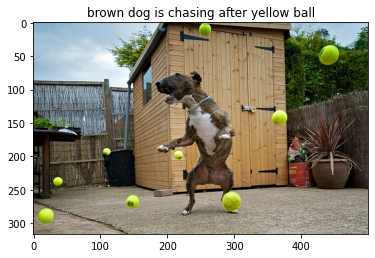

In [ ]:
i += 1
image_id = list(test_features.keys())[i]
image = plt.imread('/content/Flicker8k_Dataset/'+ image_id +'.jpg')
image_featurized = test_features[image_id]
caption = generate_caption(caption_model, image_featurized, tokenizer)
plt.imshow(image)
plt.title(caption);